In [21]:
from fmp_data import Dataset

data = Dataset(['^GSPC', '^VIX'], metrics={'close': 'close_price'}, start_date='2010-01-01', end_date='2025-01-01')
vix = data[data['symbol'] == '^VIX'].copy()
# Add rolling min and max of close_price for the last 365 days
vix['ttm_low'] = vix['close_price'].rolling(window=365, min_periods=365).min()
vix['ttm_high'] = vix['close_price'].rolling(window=365, min_periods=365).max()

spx = data[data['symbol'] == '^GSPC'].copy()


# All in SPX since day 0

In [33]:
start_date = '2011-01-03'
end_date = '2025-01-01'

allin_spx = spx[spx.date == end_date].close_price.iloc[0] / spx[spx.date == start_date].close_price.iloc[0] * 100

print(f"$100 become ${allin_spx:.1f}")

$100 become $462.4


# Timing the market with VIX

In [125]:
spx_share = 50 / spx[spx.date == start_date].close_price.iloc[0]
cash = 50

sell_date = vix[vix.close_price <= vix.ttm_low].date.values
buy_date = vix[vix.close_price <= vix.ttm_low].date.values

trades = [(d, 'sell') for d in sell_date] + [(d, 'buy') for d in buy_date]
trades.sort(key=lambda x: x[0])

record = [[start_date, 100],]
    
for t in trades:
    if t[1] == 'sell' and spx_share > 0:
        volumn = spx_share / 30 * 0
        spx_share -= volumn
        cash += volumn * spx[spx.date == t[0]].close_price.iloc[0]
    else:
        money = cash / 30
        cash -= money
        spx_share += money / spx[spx.date == t[0]].close_price.iloc[0]
    fund = cash + spx_share * spx[spx.date == t[0]].close_price.iloc[0]
    record.append([t[0], fund])

record = pd.DataFrame(record, columns=['date', 'fund'])

In [126]:
cmp = pd.merge(spx[spx.date >= start_date], record, on='date', how='left')
cmp['allin'] = cmp['close_price'] / cmp['close_price'].iloc[0] * 100
cmp['fund'] = cmp.fund.ffill()
print(cash, fund)

0.27945488827027215 371.6549675708781


In [123]:
cmp[cmp.date.isin(sell_date.tolist() + buy_date.tolist())]

,date,symbol,close_price,fund,allin
102,2011-04-15,^GSPC,1319.68,101.879516,103.759032
103,2011-04-15,^GSPC,1319.68,101.879516,103.759032
104,2011-04-16,^GSPC,1319.68,101.879516,103.759032
105,2011-04-16,^GSPC,1319.68,101.879516,103.759032
106,2011-04-17,^GSPC,1319.68,101.879516,103.759032
...,...,...,...,...,...
5035,2024-05-18,^GSPC,5303.26,406.438178,416.965570
5036,2024-05-19,^GSPC,5303.26,406.438178,416.965570
5037,2024-05-19,^GSPC,5303.26,406.438178,416.965570
5039,2024-05-21,^GSPC,5321.42,407.829948,418.393389


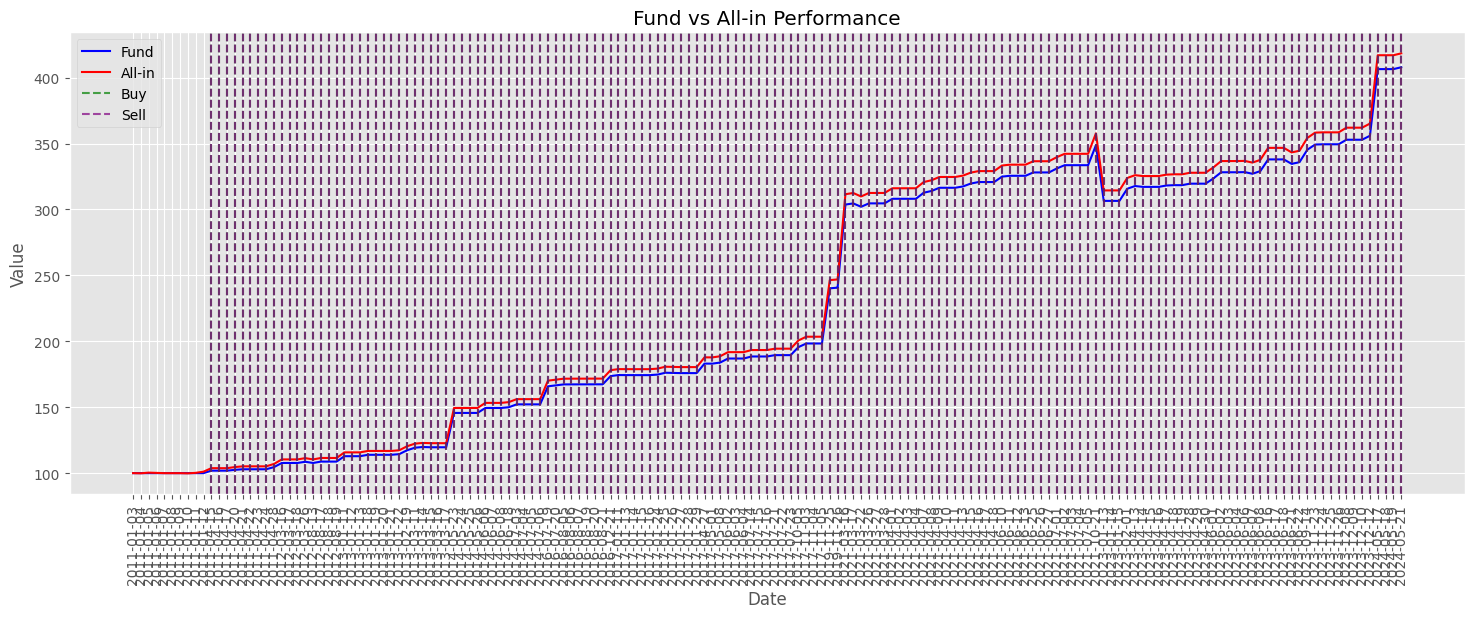

In [124]:
# Sample every 7 days
sample = cmp.iloc[0:10]
extra = set(sell_date.tolist() + buy_date.tolist()) | set(sample.date.values.tolist())
sample =  pd.concat([sample, cmp[cmp.date.isin(extra)]])
sample.sort_values('date', inplace=True)

# Create figure and axis
fig, ax = plt.subplots(figsize=(18, 6))

# Plot both series
ax.plot(sample.date, sample.fund, label='Fund', color='blue')
ax.plot(sample.date, sample.allin, label='All-in', color='red')

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Fund vs All-in Performance')
# Rotate x-axis labels for better readability
ax.tick_params(axis='x', rotation=90)
# Add vertical lines for buy and sell dates
for b in buy_date:
    ax.axvline(x=b, color='green', linestyle='--', alpha=0.7, label='Buy' if b == buy_date[0] else "")
    
for s in sell_date:
    ax.axvline(x=s, color='purple', linestyle='--', alpha=0.7, label='Sell' if s == sell_date[0] else "")


ax.legend()



In [111]:
vix[vix.close_price <= vix.ttm_low]

,date,symbol,close_price,ttm_low,ttm_high
939,2011-04-15,^VIX,15.32,15.32,45.79
941,2011-04-16,^VIX,15.32,15.32,45.79
943,2011-04-17,^VIX,15.32,15.32,45.79
949,2011-04-20,^VIX,15.07,15.07,45.79
951,2011-04-21,^VIX,14.69,14.69,45.79
...,...,...,...,...,...
10187,2023-12-12,^VIX,12.07,12.07,26.52
10501,2024-05-17,^VIX,11.99,11.99,21.71
10503,2024-05-18,^VIX,11.99,11.99,21.71
10505,2024-05-19,^VIX,11.99,11.99,21.71


In [114]:
# Find dates where VIX is above its trailing 12-month high
high_vix_dates = vix[vix.close_price >= vix.ttm_high]['date'].values
# Find those dates in cmp dataframe
high_vix_in_cmp = cmp[cmp['date'].isin(high_vix_dates)]
# For each high VIX date, find the corresponding date 30 days later in cmp
result_dates = []
for d in high_vix_dates:
    # Find the date 30 days later in cmp
    future_date = cmp[cmp['date'] > d].sort_values('date').iloc[29:30]
    if not future_date.empty:
        result_dates.append(future_date)
# Create a dictionary to store date pairs
date_pairs = {}
for d in high_vix_dates:
    future_date = cmp[cmp['date'] > d].sort_values('date').iloc[29:30]
    if not future_date.empty:
        date_pairs[d] = future_date.iloc[0]['date']

# Create DataFrame with high VIX dates and their corresponding future dates
future_dates_df = pd.DataFrame({
    'high_vix_date': list(date_pairs.keys()),
    'future_date': list(date_pairs.values())
})

# Get prices for high VIX dates and future dates
high_vix_prices = []
future_prices = []

for _, row in future_dates_df.iterrows():
    high_vix_date = row['high_vix_date']
    future_date = row['future_date']
    
    high_vix_price = cmp[cmp['date'] == high_vix_date]['close_price'].values[0]
    future_price = cmp[cmp['date'] == future_date]['close_price'].values[0]
    
    high_vix_prices.append(high_vix_price)
    future_prices.append(future_price)

# Add the price columns to future_dates_df
future_dates_df['high_vix_price'] = high_vix_prices
future_dates_df['future_price'] = future_prices

future_dates_df

,high_vix_date,future_date,high_vix_price,future_price
0,2011-08-04,2011-09-03,1200.07,1173.97
1,2011-08-05,2011-09-04,1199.38,1173.97
2,2011-08-06,2011-09-05,1199.38,1173.97
3,2011-08-07,2011-09-06,1199.38,1165.24
4,2011-08-08,2011-09-07,1119.46,1198.62
5,2014-02-03,2014-03-05,1741.89,1873.81
6,2014-10-13,2014-11-12,1874.74,2038.25
7,2014-10-15,2014-11-14,1862.49,2039.82
8,2015-08-21,2015-09-20,1970.89,1958.03
9,2015-08-22,2015-09-21,1970.89,1966.97
